In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import seaborn as sns
from typing import Dict, List, Optional, Tuple, Union
import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from utils_activations import rot13_alpha, LlamaActivationExtractor

In [2]:
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'

In [3]:
# person = "Alexander Hamilton"
# reasoning_question  = "What is the capital of the state that the first U.S. secretary of the treasury died in?"

In [4]:
person = "Hillary Clinton"
reasoning_question = "What is the capital of the state that the secretary of state of the U.S. in 2009 was born in?"

# Load model and extractor

In [5]:
activation_extractor = LlamaActivationExtractor(
    model_name_or_path=path,
    layer_defaults='even'
    )

Using device: cuda


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
activation_extractor.overwrite_chat_template()

# Get activations and response

In [7]:
formatted = activation_extractor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': reasoning_question}],
    tokenize=False,
    add_generation_prompt=True,
)
generation_results = activation_extractor.generate_with_activations(
    formatted,
    do_sample=False,
    max_new_tokens=1000,
    temperature=0.0,
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


# Logit Lens Helper Functions

In [ ]:
def logit_lens_single_layer(self, 
                           activation: torch.Tensor, 
                           apply_layer_norm: bool = True) -> torch.Tensor:
    """
    Apply logit lens to a single layer's activations.
    
    Args:
        activation: Tensor of shape (seq_len, hidden_dim) or (batch, seq_len, hidden_dim)
        apply_layer_norm: Whether to apply layer normalization before projection
        
    Returns:
        Logits tensor of shape (seq_len, vocab_size) or (batch, seq_len, vocab_size)
    """
    # Ensure activation is on the correct device
    activation = activation.to(self.device)
    
    # Apply layer normalization if requested (this is typically done in the final layer)
    if apply_layer_norm:
        activation = self.model.model.norm(activation)
    
    # Project to vocabulary space
    logits = self.model.lm_head(activation)

    return logits

# Naive Readout

In [11]:
def readout_tokens_at_layer(self, activations: Dict[str, torch.Tensor], layer_name: str) -> List[str]:
    """
    Use logit lens to read out predicted tokens at a specific layer for the entire model response.

    Args:
        activations: Dictionary of layer activations.
        layer_name: Name of the layer to analyze.

    Returns:
        List of predicted tokens for the entire response.
    """
    if layer_name not in activations:
        raise ValueError(f"Layer {layer_name} not found in activations.")

    # Get logits for the specified layer
    logits = logit_lens_single_layer(self, activations[layer_name])

    # Get predicted token IDs (argmax over vocabulary dimension)
    predicted_token_ids = torch.argmax(logits, dim=-1)

    # Decode token IDs to strings
    if logits.dim() == 2:  # Shape (seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids]
    else:  # Shape (batch, seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids[0]]

    return predicted_tokens


Predicted tokens at layer layer_10 :  underwater infinity elta 818 zia -called 508 � lessly CAC TURE pb  Bod ablish ondo  Sap ler llll hari ial ed  Oscar  Vul  consect  Barber elman quier of  poster  Shepard ty ystate ogi  consect inel axon ̆ ed 345 adal hood  Witt   dık  Cock edly nt ohan abi ail isma ilia  табли 948 .scalablytyped iences  down ogh /th 609 GP 'gc  VIP 一步 rne  Vid leigh 一步 TemplateName  Abr ampa enberg lik  Welch  Leone  ASIC тий nt  Castle ABEL  jadx  ​​  ​​  else dy  Shepard  consect � ̆  Vul ed  Pend adal wide quier emos abel  Yi dık  Cock  Yi  fore .scalablytyped preter uger .scalablytyped ondo γγ  Pend  Pend  Murdoch gow ifa wald /mit  Ev 654 ache ondo  Vul ce � axon ham  Vul  hob adal wide ़ oun  RV  Henderson  Benedict iture ぇ inha  McGu ica  � YD üre  Kirst atin lyph URITY zt atin dy  Bram  vic leigh  Claw  sher │ opsis _dbg .scalablytyped ients oq  Pend ed  Strange enberg ils  sl recision ookie FFE edList  CORE  Somerset ty born ihan 383 TemplateName etak あげ  

In [ ]:
# Specify the layer to analyze
layer_to_analyze = "layer_10"  # Replace with the desired layer name

# Call the function to read out tokens at the specified layer
predicted_tokens = readout_tokens_at_layer(
    activation_extractor, 
    generation_results['token_activations'], 
    layer_to_analyze
)

# Print the entire readout
print("Predicted tokens at layer", layer_to_analyze, ":", " ".join(predicted_tokens))

# Layer-averaged Readout

In [14]:
def readout_tokens_from_layer_average(self, activations: Dict[str, torch.Tensor], layer_names: List[str]) -> List[str]:
    """
    Use logit lens to read out predicted tokens by averaging logits over several specified layers.

    Args:
        activations: Dictionary of layer activations.
        layer_names: List of layer names to average logits over.

    Returns:
        List of predicted tokens for the entire response.
    """
    # Ensure all specified layers are in the activations
    for layer_name in layer_names:
        if layer_name not in activations:
            raise ValueError(f"Layer {layer_name} not found in activations.")

    # Collect logits for the specified layers
    logits_list = [logit_lens_single_layer(self, activations[layer_name]) for layer_name in layer_names]

    # Average the logits over the specified layers
    averaged_logits = torch.mean(torch.stack(logits_list), dim=0)

    # Get predicted token IDs (argmax over vocabulary dimension)
    predicted_token_ids = torch.argmax(averaged_logits, dim=-1)

    # Decode token IDs to strings
    if averaged_logits.dim() == 2:  # Shape (seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids]
    else:  # Shape (batch, seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids[0]]

    return predicted_tokens


In [17]:
# Example usage: Read out tokens by averaging logits over specific layers
layers_to_average = [f'layer_{i}' for i in range(0, 80, 2)] #44, 68, 2)]  # Replace with desired layer names
predicted_tokens_avg = readout_tokens_from_layer_average(activation_extractor, generation_results['token_activations'], layers_to_average)

# Print the entire readout
print("Predicted tokens from averaged layers:", " ".join(predicted_tokens_avg))

Predicted tokens from averaged layers: �от x nl  ​​  so jour  need hythm lessly  figure implify  out g  answer ur  answer  capital  capital  capital  city  State ur  state  state gr  where  where  Cond ur  US U  Secretary  Secretary  Sec intendent ary  State  State  State  affairs ในป 200  Cond  Cond  was  was  born  born  born  let  let  me r  breakdown  break s  this  this  down erty  step  step  step -by  step  step s  because  first  first gli ly  who  need ub hy q  identify  indent  indent ify sl  who  else ur  Secretary ocrats intendent ary  State  State  State  State  during  was  during 200  Cond  Obama ″  I  know  remember  remember ember  bahwa  rằng  Cond  Hillary gh ary  Clinton illary and  Clinton  served  was  Secretary ur  Secretary  Sec etary ary  State  State  State  State  during  during bing  Obama ur  period ترة  period  frame  she  served  serve  during ingga 200 200  Hillary  Obama 201  Scr  State  under q  under  President  President идент ents  Barack  Obama  Ob

# Layer-averaged Readout + Confidence Treshold

Tokens exceeding the confidence threshold:  so  figure  figure  out  answer  answer  capital  capital  city  state  where  where  Cond  US  Secretary  Secretary ary  State 200  Cond  Cond  was  was  born  let  let  me  me  breakdown  this  this  down  step  step -by  step  step  because  first  first ly  figure ify  who  Secretary ary  State  State  was 200  Cond  Obama  Cond  Hillary ary  Clinton  served  Secretary  Secretary ary  State  State  during  during  time  period  she  served 200  President ents  Barack  Obama  Obama  Obama  so  so  part  step  first  part  done  next  next  step  need  out  where ary  Clinton  was  born  she  born  somewhere  Chicago icago  Illinois  Illinois  Illinois inois inois inois  pretty  sure  sure  about  just  should  should  double  double -check -check  sure  sure  sure  correct 混  birth  birth  someone body body  else  else  yes  born  Chicago  Chicago icago  now  question  question ing  capital  capital  state  was  was  born  since  since  sh

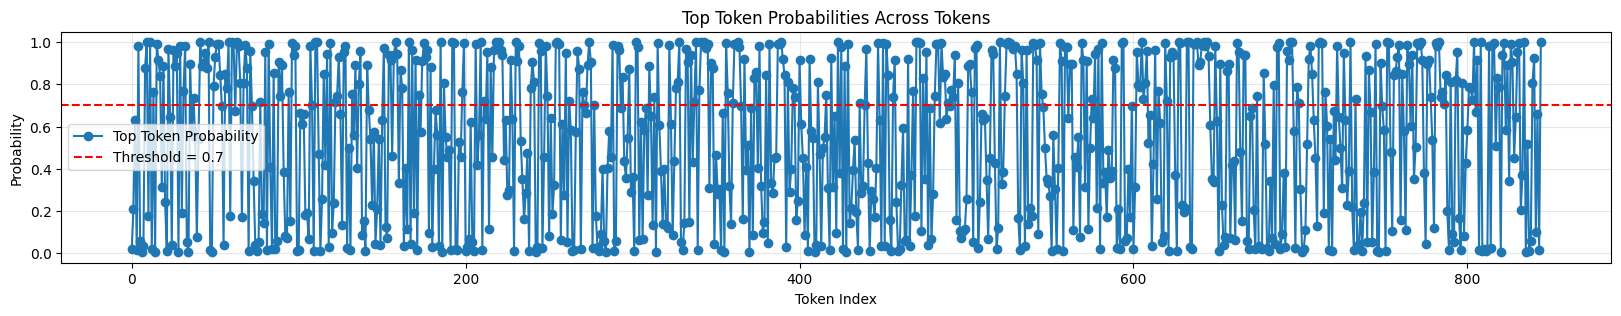

In [30]:
def plot_top_token_probabilities(self, activations: Dict[str, torch.Tensor], layer_names: List[str], confidence_threshold: float = 0.5):
    """
    Plot the probability of the top token for each predicted token, highlighting those above a confidence threshold.
    Also, print out the tokens that exceed the confidence threshold.

    Args:
        activations: Dictionary of layer activations.
        layer_names: List of layer names to average logits over.
        confidence_threshold: Probability threshold to highlight tokens.
    """
    # Ensure all specified layers are in the activations
    for layer_name in layer_names:
        if layer_name not in activations:
            raise ValueError(f"Layer {layer_name} not found in activations.")

    # Collect logits for the specified layers
    logits_list = [logit_lens_single_layer(self, activations[layer_name]) for layer_name in layer_names]

    # Average the logits over the specified layers
    averaged_logits = torch.mean(torch.stack(logits_list), dim=0)

    # Get probabilities of the top token (softmax over vocabulary dimension)
    probabilities = F.softmax(averaged_logits, dim=-1)
    top_token_probs, top_token_ids = torch.max(probabilities, dim=-1)

    # Convert to numpy for plotting
    top_token_probs = top_token_probs.detach().float().cpu().numpy()

    # Decode tokens that exceed the confidence threshold
    top_token_ids = top_token_ids.detach().cpu().numpy()
    tokens_above_threshold = [
        self.tokenizer.decode([token_id])
        for token_id, prob in zip(top_token_ids, top_token_probs)
        if prob >= confidence_threshold
    ]

    # Print tokens that exceed the confidence threshold
    print("Tokens exceeding the confidence threshold:", " ".join(tokens_above_threshold))

    # Plot the probabilities
    plt.figure(figsize=(20, 3))
    plt.plot(top_token_probs, label='Top Token Probability', marker='o')
    plt.axhline(y=confidence_threshold, color='r', linestyle='--', label=f'Threshold = {confidence_threshold}')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.title('Top Token Probabilities Across Tokens')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage: Plot top token probabilities with a confidence threshold
layers_to_average = [f'layer_{i}' for i in range(50, 66, 2)]  # Replace with desired layer names
confidence_threshold = 0.7
plot_top_token_probabilities(activation_extractor, generation_results['token_activations'], layers_to_average, confidence_threshold)

# Now smooth over tokens

Tokens exceeding the confidence threshold:  figure  figure  figure  out  capital  capt  capt  state  state  state  where  where  US  Secretary  Secretary ary  State  state  state 200  Cond  Cond  was  was  born  born  me  me  break  break  this  this  down  step  step  step  step -by  step  step  first  first ly  indent  indent ify  who  Secretary ary  State  state  state 200  Cond  Obama  remember  remember  Cond  Cond ary  Clinton  Clinton  Secretary  Secretary  State  state  state  during  during  President  time  time  period  Hillary  under  President  President  Barack  Obama  Obama  Obama  Obama  so  step  next  next  need  find  find  find  out  where  where  Hillary  Hillary ary  Clinton  was  was  born  born  she  was  was  born  Illinois  Chicago icago icago  Illinois  Illinois  Illinois inois inois inois  Chicago  Chicago  pretty  pretty  sure  sure  about  should  should  double  double -check -check -check  sure  sure  sure  not 混 混  with  someone body body  else  else  e

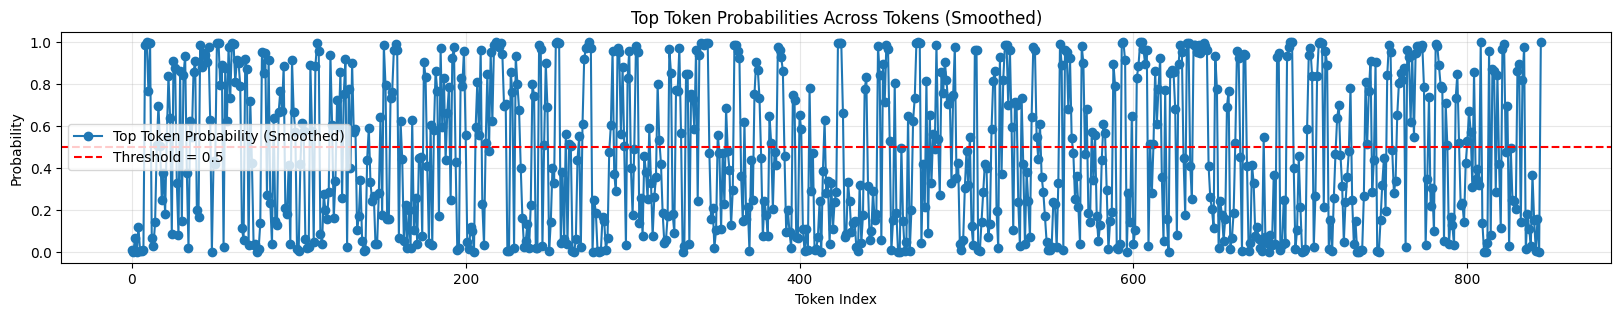

In [38]:
from scipy.ndimage import gaussian_filter1d

def plot_smoothed_top_token_probabilities(self, activations: Dict[str, torch.Tensor], layer_names: List[str], confidence_threshold: float = 0.5, smoothing_sigma: float = 1.0):
    """
    Plot the probability of the top token for each predicted token, highlighting those above a confidence threshold.
    Smooth the logits over tokens before calculating probabilities.

    Args:
        activations: Dictionary of layer activations.
        layer_names: List of layer names to average logits over.
        confidence_threshold: Probability threshold to highlight tokens.
        smoothing_sigma: Standard deviation for Gaussian smoothing.
    """
    # Ensure all specified layers are in the activations
    for layer_name in layer_names:
        if layer_name not in activations:
            raise ValueError(f"Layer {layer_name} not found in activations.")

    # Collect logits for the specified layers
    logits_list = [logit_lens_single_layer(self, activations[layer_name]) for layer_name in layer_names]

    # Average the logits over the specified layers
    averaged_logits = torch.mean(torch.stack(logits_list), dim=0)

    # Smooth the logits over tokens
    if averaged_logits.dim() == 2:  # Shape (seq_len, vocab_size)
        smoothed_logits = torch.tensor(gaussian_filter1d(averaged_logits.detach().float().cpu().numpy(), sigma=smoothing_sigma, axis=0))
    else:  # Shape (batch, seq_len, vocab_size)
        smoothed_logits = torch.tensor(gaussian_filter1d(averaged_logits.detach().float().cpu().numpy(), sigma=smoothing_sigma, axis=1))

    # Get probabilities of the top token (softmax over vocabulary dimension)
    probabilities = F.softmax(smoothed_logits, dim=-1)
    top_token_probs, top_token_ids = torch.max(probabilities, dim=-1)

    # Convert to numpy for plotting
    top_token_probs = top_token_probs.detach().float().cpu().numpy()

    # Decode tokens that exceed the confidence threshold
    top_token_ids = top_token_ids.detach().cpu().numpy()
    tokens_above_threshold = [
        self.tokenizer.decode([token_id])
        for token_id, prob in zip(top_token_ids, top_token_probs)
        if prob >= confidence_threshold
    ]

    # Print tokens that exceed the confidence threshold
    print("Tokens exceeding the confidence threshold:", " ".join(tokens_above_threshold))

    # Plot the probabilities
    plt.figure(figsize=(20, 3))
    plt.plot(top_token_probs, label='Top Token Probability (Smoothed)', marker='o')
    plt.axhline(y=confidence_threshold, color='r', linestyle='--', label=f'Threshold = {confidence_threshold}')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.title('Top Token Probabilities Across Tokens (Smoothed)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage: Plot smoothed top token probabilities with a confidence threshold
layers_to_average = [f'layer_{i}' for i in range(50, 66, 2)]  # Replace with desired layer names
layers_to_average = ['layer_60']
confidence_threshold = 0.5
smoothing_sigma = 0.75
plot_smoothed_top_token_probabilities(activation_extractor, generation_results['token_activations'], layers_to_average, confidence_threshold, smoothing_sigma)